In [1]:
import warnings
warnings.filterwarnings("ignore")

# simples tutorial word2vec com o Gensim

Gensim é uma biblioteca que de forma simples e nada burocratica nos permite usar vários algoritmos voltados para processamento de linguagem natural. Aqui falarei sobre como usar o word2vec e interagir um pouco com o skip-gram e cbow, mais à frente explicarei o que cada um é.

## 1. pegando um texto

* pegar um artigo na wikipédia
* limpando o texto!
    - remover pontuação, converter para minúsculas, etc.
    - remover stopwords (palavras que não nos interessam tanto e se repetem muito como "que", "até", "mas", etc)

In [2]:
import wikipedia

In [3]:
wikipedia.set_lang("pt")
text = wikipedia.page("Pernambuco").content.splitlines()

In [4]:
# bibliotecas principais para processar o texto
import gensim
import nltk

In [5]:
stop_words = nltk.corpus.stopwords.words("portuguese")

In [6]:
sentences = []

for t in text:
    if len(t) > 0:
        new_t = gensim.utils.simple_preprocess(t) # lowecase > split str > remove pontuação
        new_t = [i for i in new_t if i not in stop_words]
        sentences.append(new_t)

In [7]:
len(sentences) # number of sentences

142

## 2. skip-gram e cbow

Uma das grandes vantagens do word2vec é que ele por si não é um fim, mas uma base para outros algoritmos, a idéia por trás é verdadeiramente simples: usar esses pares de ids para evidenciar a relação entre as palavras e assim poder usar outros métodos como o skip-gram e o cbow para identificar padrões e encontrar palavras semanticamente próximas ou classificar textos, por exemplo.

### 2.1 skip-gram

Usamos uma rede neural para predizer a probabilidade do uso de alguma palavra com base em outra, ex.:

```python
word = "computador"

pares = [("computador", "ibm"),
         ("computador", "sistema"),
         ("computador", "componentes"),
         ...
        ]
```

Logicamente, no uso real lidamos com ids já que o processamento é a nível numérico, mas a idéia é a partir desses pares compreender as propabilidades de uso das palavras e assim acabamos identificando uma proximidade semântica.

Desse modo temos como entrada uma palavra e como saída as palavras mais prováveis dela estar relacionada.

### 2.2 cbow

O cbow segue um caminho quase que contrário ao skip-gram, partimos das relações entre palavras (dos pares de ids) para predizer a palavra central. Dessa forma também chegamos a uma ~estatística~ de proximidade semântica.

Seguindo a lógica do exemplo acima, no cbow partimos de "ibm", "sistema", "componentes", etc para predizer a palavra "computador"

Imagem que ilustra a arquitetura dos dois modelos, esta imagem está no artigo [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)

![](skip-gram_cbow.png)

O parâmetro que define o uso de um ou outro método é o `sg` (sigla de skip-gram), e diferentemente de outras bibliotecas onde se usa *True* ou *False*, nele usamos 1 ou 0, por padrão é 0. Então se `sg=0` o método usado será o cbow e se `sg=1` o método usado será o skip-gram

In [12]:
# sg=1 ~> skip-gram mode, if sg=0 ~> cbow mode

model_sg = gensim.models.Word2Vec(sentences, min_count=1, window=2, compute_loss=True, sg=1) 
model_sg.train(sentences, total_examples=len(sentences), epochs=100)

model_cb = gensim.models.Word2Vec(sentences, min_count=1, window=2, compute_loss=True, sg=0) 
model_cb.train(sentences, total_examples=len(sentences), epochs=100)

(763662, 801300)

In [13]:
# acessando o vocabulário
words = list(model_cb.wv.vocab)
words[:10]

['pernambuco',
 'unidades',
 'federativas',
 'brasil',
 'localizado',
 'centro',
 'leste',
 'região',
 'nordeste',
 'limites']

In [14]:
# repare que a matriz de saída de ambos os métodos no gensim tem as mesmas dimensões

model_sg["recife"].shape, model_cb["recife"].shape

((100,), (100,))

### 3 visualização

Devido à nossa impossibilidade de visualizar algo em 100 dimensões, usei o sklearn para reduzir as dimensões para 2, o algoritmo usado é o Principal component analysis (PCA), mais detalhes sobre ele na [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) e [aqui](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

O objetivo do PCA é permitir a visualização da distribuição, lógico que acabam-se perdendo informações e analisando mais à frente a similaridade vamos notar algumas discrepâncias entre o resultado da similaridade entre as palavras e os pontos mais proximos nos gráficos, o que é bem previsível tendo em vista a redução de 100 dimensões para 2

In [15]:
from sklearn.decomposition import PCA

In [16]:
# para começar, pegando as matrizes, terão no total (tamanho do vocabulário x 100)

X_sg = model_sg[model_sg.wv.vocab]
X_cb = model_cb[model_cb.wv.vocab]

In [17]:
(X_cb.shape, X_sg.shape) # 3472 palavras!

((3472, 100), (3472, 100))

In [18]:
# n_components ~> dimensões de saída

pca_sg = PCA(n_components=2)
result_sg = pca_sg.fit_transform(X_sg)

pca_cb = PCA(n_components=2)
result_cb = pca_cb.fit_transform(X_cb)

In [19]:
# agora temos 2 dimensões para cada palavra
result_sg.shape

(3472, 2)

In [20]:
import altair as alt
import pandas as pd # infelizmente o altair exige o pandas

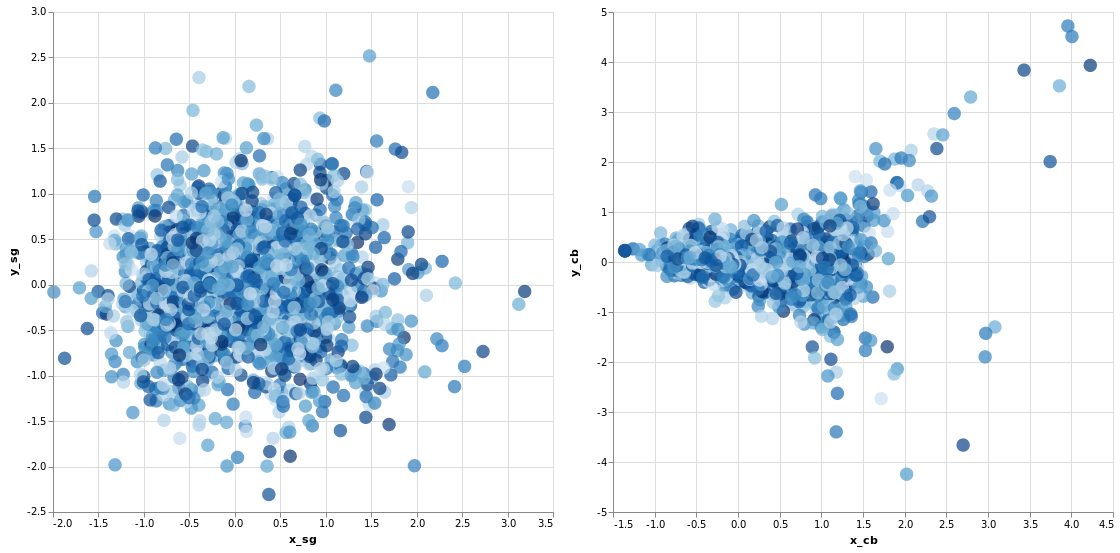

In [21]:
alt.themes.enable('opaque')
alt.renderers.enable('jupyterlab')

selector = alt.selection_multi(empty='all', fields=['label'])
base = alt.Chart(pd.DataFrame({
        "x_sg" : result_sg[:, 0],
        "y_sg" : result_sg[:, 1],
        "x_cb" : result_cb[:, 0],
        "y_cb" : result_cb[:, 1],
        "label" : words
    })).properties(
        width=500,
        height=500
    ).add_selection(selector)

c1 = base.mark_circle(size=180).encode(
        x="x_sg",
        y="y_sg",
        tooltip="label",
        color=alt.condition(selector, 'label:O', alt.value('transparent'), legend=None)
    )

c2 = base.mark_circle(size=180).encode(
        x="x_cb",
        y="y_cb",
        tooltip="label",
        color=alt.condition(selector, 'label:O', alt.value('transparent'), legend=None)
    )

c1|c2

> use o shift + click para ir selecionando vários, e passe o mouse para ver as palavras que cada ponto representa

## 4. similaridade

O comportamento mais natural diante de um gráfico como esses acima é considerar a similaridade pela proximidade entre 2 pontos através da distância euclidiana, só que este é um caso que exige outro cálculo: **similaridade de cossenos**

este cálculo é bem útil no processamento de palavras que fizemos já que as características de todo o processo são bem distintos de apenas criar regiões num gráfico, neste caso é mais relevante tratar com a diferença entre ângulos de vetores do que usarmos uma régua entre os pontos.

para compreender melhor as diferenças entre similaridade de cossenos e distância euclidiana, recomendo este [link](https://cmry.github.io/notes/euclidean-v-cosine) e para ver outros cálculos que podem ser úteis mais à frente, recomendo este [link](http://dataaspirant.com/2015/04/11/five-most-popular-similarity-measures-implementation-in-python/) que tem ótimas imagens ilustrativas.

> obs sobre similaridade: o gensim tem vários métodos (descrições das docstrings)
>
> * similarity_matrix: Construct a term similarity matrix for computing Soft Cosine Measure.
> * similarity: Compute cosine similarity between two words.
> * most_similar_cosmul: using the multiplicative combination objective, proposed by `Omer Levy and Yoav Goldberg "Linguistic Regularities in Sparse and Explicit Word Representations"
> * similar_by_word: (a docstring não diz mas usa similaridade de cossenos)
> * similar_by_vector: Find the top-N most similar words by vector.

In [22]:
# palavra escolhida para ver quais as mais similares de acordo com cada método
w = "cozido"

In [23]:
# repare que quanto mais próximo de 1, mais similar
model_sg.wv.most_similar(w)

[('moqueca', 0.9971297383308411),
 ('peixada', 0.996859073638916),
 ('chambaril', 0.9953799247741699),
 ('caldeirada', 0.9873913526535034),
 ('cavalos', 0.9756345152854919),
 ('culminando', 0.9740967750549316),
 ('doçaria', 0.9523752927780151),
 ('implicados', 0.9476878643035889),
 ('abastados', 0.9454045295715332),
 ('charque', 0.9385865330696106)]

In [24]:
print("skip-gram \t| cbow")
print("-" * 20)
for i in zip(model_sg.wv.similar_by_word("cozido"), model_cb.wv.similar_by_word("cozido")):
    print(i[0][0],"\t| " , i[1][0])


skip-gram 	| cbow
--------------------
moqueca 	|  moqueca
peixada 	|  doces
chambaril 	|  abastados
caldeirada 	|  qualidade
cavalos 	|  insatisfeita
culminando 	|  nobreza
doçaria 	|  cavalos
implicados 	|  culminando
abastados 	|  chamada
charque 	|  chambaril


Como todos nós sabemos, a palavra "cozido" se refere à comida (ao menos na maior parte do tempo, costumo dizer que no verão aqui em Recife somos cozidos ao sol, mas isto não vem ao caso), mas o fato é que com base no conteúdo de 1 único artigo na wikipédia, a similaridade pôde inferir até que com bastante precisão o contexto de uso, dos 10 resultados mais próximos no skip-gram, os 4 primeiros inferem diretamente de acordo com o que consideramos correto (dependendo do lugar no mundo podem considerar os 5 primeiros) e as demais palavras compreendemos que pode fazer sentido elas estarem alí pelo que é contado no texto sobre Pernambuco, então é compreensível que em algum momento fale sobre classes abastadas em relação à história da culinária.

Se formos verificar o texto vamos considerar essa impressão errônea, lá está escrito: "Antes, as canoas eram o principal meio de transporte de pessoas e cargas da capital pernambucana, e para os mais abastados, cavalos e carruagens.", sabendo disso podemos apostar em alguns fatores:

* foi 1 único artigo, então a margem de erro é alta, afinal não usamos nada específico de culinária que envolvesse "cozido", mais texto == mais precisão?
* faltou mais treinamento?
* que algoritmos foram usados na função de ativação, erro e otimização? como poderemos saber se são os mais adequados à essa situação?

Futuramente vou implementar esses algoritmos manualmente e essas dúvidas serão exploradas